The goal of this notebook is to classify as event or not event WordNet nominal synsets associated to VerbAtlas frames but that do not reach the "event" synset through the hyponyms tree. For this purpose a neural network has been trained that classifies the synset, based on its definition, as event or not event.

#Imports and Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import json
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModel

# For iteration bars
from tqdm.auto import tqdm

# Nltk wordnet
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Set the seed for the randoms
def set_random_seed():
    SEED = 104
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
set_random_seed()

# Paths
# path to folder that contains files
# ROOT_PATH = "./drive/MyDrive/EAI/NLP/HW2/Project_NUANS/"
ROOT_PATH = "./drive/MyDrive/Project_NUANS/"
CHECKPOINTS_PATH = ROOT_PATH + "Model_ckp/"
DATASETS_PATH = ROOT_PATH + "Datasets/"
OUTPUT_PATH = ROOT_PATH + "Outputs/"

# Patience
LEN_STACK_PATIENCE = 4
PATIENCE = 5
# Optim
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 0.01
TRANSFORMER_LEARNING_RATE = 5e-5
TRANSFORMER_WEIGHT_DECAY = 0.0
# Training
BATCH_SIZE = 32
EPOCHS = 100
# Architecture~||
HIDDEN_DIM_LSTM = 200
POS_EMBEDDING_DIM = 128
BIDIRECTIONAL = True
NUM_LAYER_LSTM = 3
DROPOUT = 0.2
DROPOUT_LSTM = 0.5

# Other
TRANFORMER_CHECKPOINT = "bert-base-uncased"
TOKENIZER = AutoTokenizer.from_pretrained(TRANFORMER_CHECKPOINT)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

POS = ["<PAD>", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
       "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
LABEL = ["not_event", "event"]

def encode(list_to_encode):
    id2code= {}
    code2id = {}
    for id, code in enumerate(list_to_encode):
        id2code[id] = code
        code2id[code] = id
    return id2code, code2id
ID_TO_LABEL, LABEL_TO_ID = encode(LABEL)
ID_TO_POS, POS_TO_ID = encode(POS)

device: cuda


# Functions and Classes

In [ ]:
def pprint(obj):
    '''
        Indented print of an object
    '''
    print(json.dumps(obj, indent=3))

def data_loading(dataset, shuffle):
    """
    Function used to create a dataloader and print some usefull information.
    Args:
        dataset: dataset on which you want to build the dataloader
        shuffle: whether or not I should shuffle the dataloader obtained 
    Return:
        data_loader: the DataLoader object
    """
    data_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = shuffle)
    print(dataset)
    print("batch size: " + str(BATCH_SIZE))
    print("number of batches: " + str(len(data_loader)))
    return data_loader

def pos_tagging(sentence):
    '''
    Function that use nltk to tokenize the sentence in input and then map the 
    nltk pos tag into universal pos tag
    Args:
        sentence: sentence from which the pos tag is obtained 
    Return:
        universal_pos_tags: universal pos tag associated to the input sentence
    '''
    pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
    universal_pos_tags = []
    for word, pos in pos_tags:
        if pos in ["JJ", "JJR", "JJS"]:
            universal_pos_tags.append((word, "ADJ"))
        elif pos in ["IN"]:
            universal_pos_tags.append((word, "ADP"))
        elif pos in ["RB", "RBR", "RBS"]:
            universal_pos_tags.append((word, "ADV"))
        elif pos in ["MD"]:
            universal_pos_tags.append((word, "AUX"))
        elif pos in ["CC"]:
            universal_pos_tags.append((word, "CCONJ"))
        elif pos in ["DT", "PDT", "WDT"]:
            universal_pos_tags.append((word, "DET"))
        elif pos in ["UH"]:
            universal_pos_tags.append((word, "INTJ"))
        elif pos in ["NN", "NNS", "NNP", "NNPS"]:
            universal_pos_tags.append((word, "NOUN"))
        elif pos in ["CD"]:
            universal_pos_tags.append((word, "NUM"))
        elif pos in ["POS"]:
            universal_pos_tags.append((word, "PART"))
        elif pos in ["PRP", "PRP$", "WP", "WP$"]:
            universal_pos_tags.append((word, "PRON"))
        elif pos in ["NNP", "NNPS"]:
            universal_pos_tags.append((word, "PROPN"))
        elif pos in [".", ",", ":", "!", "?"]:
            universal_pos_tags.append((word, "PUNCT"))
        elif pos in ["IN"]:
            universal_pos_tags.append((word, "SCONJ"))
        elif pos in ["SYM"]:
            universal_pos_tags.append((word, "SYM"))
        elif pos in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:
            universal_pos_tags.append((word, "VERB"))
        else:
            universal_pos_tags.append((word, "X"))
    return universal_pos_tags

MyDataset \
Class that reads and preprocesses sets for "event identification" step (binary classifier "event", "not event")

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mode):
        """
        Args:
            mode: "train": if I want use the training set 
                  "dev":   if I want use the development set
                  "test":  if I want use the test set
                  "final": if I want use the final set, namely the one to classify as event or not event
                           without labels. Samples that will be classified as event will 
                           be added to the "classication step" (VerbAtlas frame classification)
        """
        self.mode = mode
        self.transformer_name = TRANFORMER_CHECKPOINT
        self.dataset = self.read_dataset()
        self.sentences, self.labels, self.pos, self.synsets = self.sentence_from_data()
        self.encoded_data = self.encode()

    def read_dataset(self):
        '''
        Function used to read the datasets
        Return:
            sets: datasets loaded
        '''
        with open(DATASETS_PATH + "dataset_identification.json", "r") as f:
            sets = json.load(f)
        return sets
    
    def sentence_from_data(self):
        """
        Method used to extract the necessary information from the dataset 
        and apply initial preprocessing.
        Return:
            sentences: list of words of the synset definition and its hypernims definition. 
            labels:    list of labels.
            pos:       list of part of speech tags for each word.
            synsets:   list of names of synsets.
        """
        sentences = []
        labels = []
        pos = []
        synsets = []
        for synset, synset_info in self.dataset[self.mode].items():
            hypernyms = wn.synset(synset[8:-2]).hypernyms()
            sentence_pos = synset_info[0] if self.mode != "final" else synset_info
            for hypernym in hypernyms:
                sentence_pos.append(["[SEP]", "<PAD>"])
                hypernym_pos = pos_tagging(hypernym.definition())
                sentence_pos += hypernym_pos
            if self.mode != "final":
                sentences.append([item[0] for item in sentence_pos])
                pos.append([item[1] for item in sentence_pos])
                labels.append(synset_info[1])
            else:
                sentences.append([item[0] for item in sentence_pos])
                pos.append([item[1] for item in sentence_pos])
            synsets.append(synset)
        return sentences, labels, pos, synsets

    def encode(self):
        """
        Method used to convert the preprocess performed by "sentence_from_data()" 
        to an encoding that the model can read.
        Return:
            encoded: list of the input of the model:
                     {
                         transformer_inputs: tokenized sentence,
                         labels: for each sentence a label is event or not event;
                         pos_idx: list of indices that identify which pos has a word, 
                                  0 is the pad token
                     }
        """
        tokenized = TOKENIZER(
            self.sentences, 
            return_tensors = "pt", 
            truncation = True, 
            padding = True,
            is_split_into_words = True
        )
        tokenized.to(DEVICE)
        encoded = []
        for i in range(len(tokenized["input_ids"])):
            entry = {}
            for key, value in tokenized.items():
                entry[key] = value[i]
            word_ids = tokenized.word_ids(batch_index=i)
            previous_word_idx = None
            pos = []
            end_sentence = False
            for word_idx in word_ids:
                # Special tokens have a word id that is None.
                # pos for those tokens is set to pad
                if word_idx is None:
                    pos.append(POS_TO_ID["<PAD>"])
                # For the first token of each word.
                elif word_idx != previous_word_idx:
                    pos.append(POS_TO_ID[self.pos[i][word_idx]])
                # For the other tokens pos is set to pad
                else:
                    pos.append(POS_TO_ID["<PAD>"])
                previous_word_idx = word_idx
            input = {"transformer_inputs": entry,
                     "pos_idx": torch.LongTensor(pos).to(DEVICE)}
            # in "final" set there are no labels
            if self.mode != "final":
                input["labels"] =  LABEL_TO_ID[self.labels[i]]
            encoded.append(input)
        return encoded

    def __len__(self):
        '''
        Return:
            - number of element in the dataset
        '''
        return len(self.encoded_data)

    def __getitem__(self, idx):
        '''
        Return:
            - i-th element of the dataset to iterate on it
        '''
        return self.encoded_data[idx]

    def __str__(self):
        out = "set type: " + self.mode + "Set"
        out += "\ntokenizer used: " + TRANFORMER_CHECKPOINT
        out += "\nset length: " + str(len(self))
        return out

In [ ]:
class Attention_LSTM(nn.Module):
    # Attention layer used to weight the outputs of the LSTM
    def __init__(self, hidden_size):
        super(Attention_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, inputs):
        # inputs has shape (batch_size, seq_len, hidden_size * 2)
        # Calculate the attention weights using a linear layer
        attn_weights = self.attention_weights(inputs)
        # Apply a softmax function to get a probability distribution over the sequence
        attn_weights = F.softmax(attn_weights, dim=1)
        # Multiply the weights by the inputs to get a weighted sum
        weighted_inputs = torch.bmm(attn_weights.transpose(1,2), inputs)
        # Return the weighted sum and the attention weights
        return weighted_inputs, attn_weights

class Event_identification(nn.Module):
    def __init__(self, hparams):
        super(Event_identification, self).__init__()

        self.hparams = hparams

        # Number of classes
        self.num_labels = hparams["num_labels"]
        
        # Pos embedding
        self.pos_embedding = torch.nn.Embedding(hparams["pos_number"], hparams["pos_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["pos_dim"]
        
        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = hparams["dropout_lstm"] if hparams["num_layers_LSTM"] > 1 else 0,
                            batch_first = True)
    
        # If the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        # Attention mask
        self.attention = Attention_LSTM(lstm_output_dim).to(DEVICE)
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, 1) # with binary classification we have only one output
        # Activation function for binary classification
        self.activation = nn.Sigmoid()
        # Dropout
        self.dropout = torch.nn.Dropout(hparams["dropout"])

        self.train()
    
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        labels: torch.Tensor = None,
        pos_idx: torch.Tensor = None,
        compute_loss = True
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)
        transformers_outputs_sum = self.dropout(transformers_outputs_sum)

        pos_embedding = self.pos_embedding(pos_idx).squeeze(2)
        tr_out_with_predicate = torch.cat((transformers_outputs_sum, pos_embedding), dim = -1)

        embeddings = self.dropout(tr_out_with_predicate)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        attn_outputs, attn_weights = self.attention(o)
        c = self.classifier(attn_outputs)
        c = self.activation(c)
        c = c.view(-1)
        output = {"identification": c}
        if compute_loss:
          output["loss"] = self.compute_loss(c, labels)
        return output
    
    def compute_loss(
        self, 
        preds: torch.Tensor, 
        labels: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the loss of the model.
        Args:
            preds (`torch.Tensor`):
                The predictions of the model.
            labels (`torch.Tensor`):
                The labels of the model.
        Returns:
            obj:`torch.Tensor`: The loss of the model.
        """
        return F.binary_cross_entropy(preds, labels)

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, chk_name):
        """
        Args:
            model: model to train
            optimizer: optimizer to use
            chk_name: name of the checkpoint
        """
        self.model = model
        self.optimizer = optimizer
        self.chk_name = chk_name
    
    def save_model(self, model_name):
        '''
        Method used for save the model.
        '''
        torch.save(self.model.state_dict(),
                            os.path.join(CHECKPOINTS_PATH, "name__" + model_name + "___" + self.chk_name))

    def train(self, train_dataset, valid_dataset, epochs = 100):
        """
        Train the model.
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing 
                           the training instances;
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                           learning progress;
            epochs: the number of times to iterate over train_dataset.
        Returns:
            train_losses: list of the training losses over the epochs;
            valid_losses; list of the validation losses over the epochs;
            epoch: number of the last epoch (less than epochs if early stopepd).
        """
        # EARLY STOPPING VARIABLES
        # Current patience
        self.patience = 0
        # Temporal window of validation losses
        self.patience_stack = [1000 for _ in range(LEN_STACK_PATIENCE*2)]

        # Number of samples in the training set
        self.n_sample = len(train_dataset)
        # List of training losses
        train_losses = []

        # List of training losses
        valid_losses = []
        # Validation loss
        valid_loss = 1000.0
        best_valid_loss = 1000.0

        # Start!
        for epoch in tqdm(range(epochs), desc = "Epochs", leave = False):
        # Start training
            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            batch_pbar = tqdm(train_dataset, desc = "Training - Batch", leave = False)
            for batch in batch_pbar:
                self.optimizer.zero_grad()
                
                # prediction
                labels = torch.LongTensor(batch["labels"])
                labels = labels.type(torch.FloatTensor).to(DEVICE)
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": labels,
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)
                
                # Compute gradient
                sample_loss = output["loss"]
                sample_loss.backward()

                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': valid_loss, 'training_loss': sample_loss.item(), 'patience': self.patience})
        
            # training epoch loss
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_losses.append(avg_epoch_loss)
            # validation loss
            valid_loss = self.evaluate(valid_dataset)
            valid_losses.append(valid_loss)

            # Save checkpoint if valid_loss is the best one
            if (valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                self.save_model("Event_identification_model")

            # Patience check
            patience_counter = 0
            # Count how many times the validation loss is greater than 
            # that obtained in the previous LEN_STACK*2 epochs
            for past_val_loss in self.patience_stack:
                if past_val_loss < valid_loss:
                    patience_counter += 1
            # If it is greater than at least LEN_STACK_PATIENCE epochs, 
            # then increase the patience
            if (patience_counter >= LEN_STACK_PATIENCE):
                self.patience += 1
            # Otherwise decrease it
            else:
                self.patience -= 1
                if self.patience < 0:
                    self.patience = 0
            # If the patience has reached its limit... early stopping!
            if (self.patience == PATIENCE):
                print()
                print("Early stopping!!")
                break
            self.patience_stack = self.patience_stack[1:] + [valid_loss]
        return train_losses, valid_losses, epoch

    def evaluate(self, valid_dataset):
        """
        Evaluate the model.
        Args:
            valid_dataset: the dataset to use to evaluate the model.
        Return:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0 and dont compute gradient.
        self.model.eval()
        with torch.no_grad():
            batch_pbar = tqdm(valid_dataset, desc = "Validation - Batch", leave = False)
            for batch in batch_pbar:
                # Make the predictions
                labels = torch.LongTensor(batch["labels"])
                labels = labels.type(torch.FloatTensor).to(DEVICE)
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": labels,
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)

                # Save the loss
                sample_loss = output["loss"]
                valid_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': sample_loss.item(), 'patience': self.patience})
        avg_valid_loss = valid_loss / len(valid_dataset)              
        return avg_valid_loss
    
    def test(self, test_dataset):
        """
        Test the model.
        Args:
            test_dataset: the dataset to use to test the model.
        Return:
            f1, accuracy, precision, recall scores
        """
        # set dropout to 0 and dont compute gradient.
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            batch_pbar = tqdm(test_dataset, desc="Test - Batch", leave=False)
            for batch in batch_pbar:
                # Make the predictions
                labels = torch.LongTensor(batch["labels"])
                labels = labels.type(torch.FloatTensor).to(DEVICE)
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": labels,
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)

                # Append the predictions and true labels for the current batch
                y_true.extend(labels.cpu())
                y_pred.extend(output["identification"].round().tolist())

            # Compute the metrics over all the batches
            f1 = f1_score(y_true, y_pred, average="weighted")
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average="weighted")
            recall = recall_score(y_true, y_pred, average="weighted")
        print("f1:", f1)
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        return f1, accuracy, precision, recall

# Execution

In [ ]:
# Read datasets
print("Reading Train Set...")
train_dataset = MyDataset("train")
train_data_loader = data_loading(train_dataset, True)

print("\nReading Dev Set...")
dev_dataset = MyDataset("dev")
dev_data_loader = data_loading(dev_dataset, False)

print("\nReading Test Set...")
test_dataset = MyDataset("test")
test_data_loader = data_loading(test_dataset, False)

print("\nReading Final Set...")
final_dataset = MyDataset("final")
final_data_loader = data_loading(final_dataset, False)

Reading Train Set...
set type: trainSet
tokenizer used: bert-base-uncased
set length: 11068
batch size: 32
number of batches: 346

Reading Dev Set...
set type: devSet
tokenizer used: bert-base-uncased
set length: 2374
batch size: 32
number of batches: 75

Reading Test Set...
set type: testSet
tokenizer used: bert-base-uncased
set length: 2376
batch size: 32
number of batches: 75

Reading Final Set...
set type: finalSet
tokenizer used: bert-base-uncased
set length: 2390
batch size: 32
number of batches: 75


In [ ]:
# HYPER PARAMETERS SETTING
hparams = {
    "transformer_name": TRANFORMER_CHECKPOINT,
    "num_labels": len(LABEL),
    "dropout": DROPOUT,
    "dropout_lstm": DROPOUT_LSTM,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "num_layers_LSTM": NUM_LAYER_LSTM,
    "bidirectional": BIDIRECTIONAL,
    "pos_number": len(POS),
    "pos_dim": POS_EMBEDDING_DIM
}
# model initialization
model = Event_identification(hparams).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# HYPER PARAMETERS FOR SAVING
save_hparams = {
    "trans_name": TRANFORMER_CHECKPOINT,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "pos_dim": POS_EMBEDDING_DIM,
    "lr": LEARNING_RATE,
    "wd": WEIGHT_DECAY,
    "trans_lr": TRANSFORMER_LEARNING_RATE,
    "trans_wd": TRANSFORMER_WEIGHT_DECAY,
    "batch": BATCH_SIZE,
    "n_layer_LSTM": NUM_LAYER_LSTM,
    "drop": DROPOUT,
    "drop_LSTM": DROPOUT_LSTM
}
chk_name = str(save_hparams).replace("\n", " ").replace("{", "").replace("}", "").replace("'", "").replace(":", "").replace(",", "_").replace(" ", "__")
chk_name += ".pt"

# optimizer settings
groups = [
  {
    "params": model.classifier.parameters(),
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
  },
  {
    "params": model.transformer_model.parameters(),
    "lr": TRANSFORMER_LEARNING_RATE,
    "weight_decay": TRANSFORMER_WEIGHT_DECAY,
  },
]
optimizer = torch.optim.Adam(groups)

# trainer
trainer = Trainer(model, optimizer, chk_name)

In [ ]:
# model training
train_losses, valid_losses, epoch = trainer.train(train_data_loader, dev_data_loader, EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/346 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/75 [00:00<?, ?it/s]


Early stopping!!


#Best result

Best result with the following parameters: \
LEARNING_RATE = 4e-4 \
WEIGHT_DECAY = 0.01 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 32 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 3 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.5 \
ALL_HYPERNYMS = True


The lowest loss is at the epoch 8


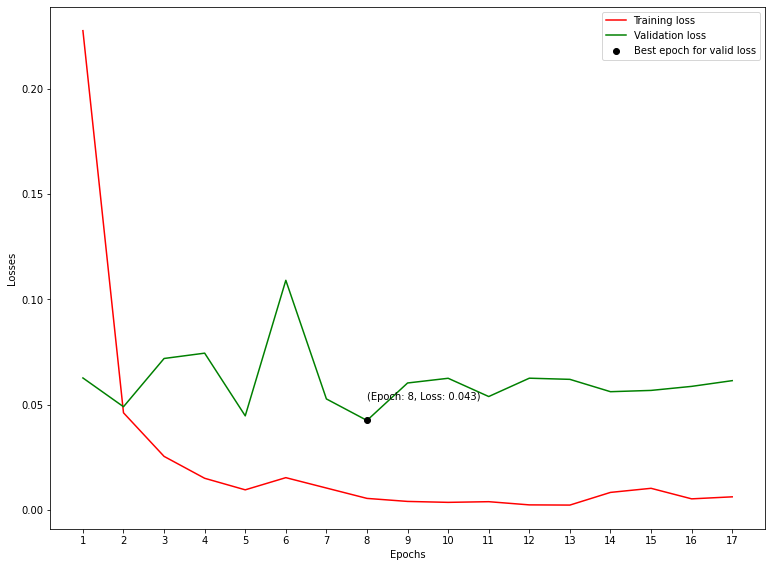

In [ ]:
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Esthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

In [ ]:
trainer.test(test_data_loader)

f1: 0.9924242424242424
accuracy: 0.9924242424242424
precision: 0.9924242424242424
recall: 0.9924242424242424


# Identification Step
From the final dataset synsets will be classified as event or not event. A synset is classified as event if the model is very sure that it is an event, namely with a prediction over a certain value. 

In [ ]:
# load checkpoint 
checkpoint_path = CHECKPOINTS_PATH + 'Event_identification_model.pt'
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(DEVICE)

In [ ]:
event = 0
synset2label = {}
for i in tqdm(range(len(final_dataset)), desc = "element", leave = False):
    input_ids = final_dataset[i]["transformer_inputs"]["input_ids"]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = final_dataset[i]["transformer_inputs"]["attention_mask"]
    attention_mask = attention_mask.unsqueeze(0)
    token_type_ids = final_dataset[i]["transformer_inputs"]["token_type_ids"]
    token_type_ids = token_type_ids.unsqueeze(0)
    pos_idx = final_dataset[i]["pos_idx"]
    pos_idx = pos_idx.unsqueeze(0)
    model_input = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids,
        "pos_idx": pos_idx,
        "compute_loss": False
    }
    synset = final_dataset.synsets[i][8:-2]
    if model(**model_input)["identification"][0].tolist()>0.99:
        event += 1
        synset2label[synset] = 'event'
    else:
        synset2label[synset] = 'not_event'
print("number of event synset:", event)
print("number of not event synset:", len(final_dataset) - event)

number of event synset: 854
number of not event synset: 1536


In [ ]:
# Save the dictionary in a JSON file
save_path = OUTPUT_PATH + "event_identification_step_results.json"
with open(save_path, "w") as file:
    json.dump(synset2label, file)

# Other results
Results obtained with different hyperparameters and techniques but with worst results

LEARNING_RATE = 5e-4 \
WEIGHT_DECAY = 0.01 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 32 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.5 \
TRANFORMER_CHECKPOINT = "bert-base-uncased" \
ALL_HYPERNYMS = False



The lowest loss is at the epoch 2


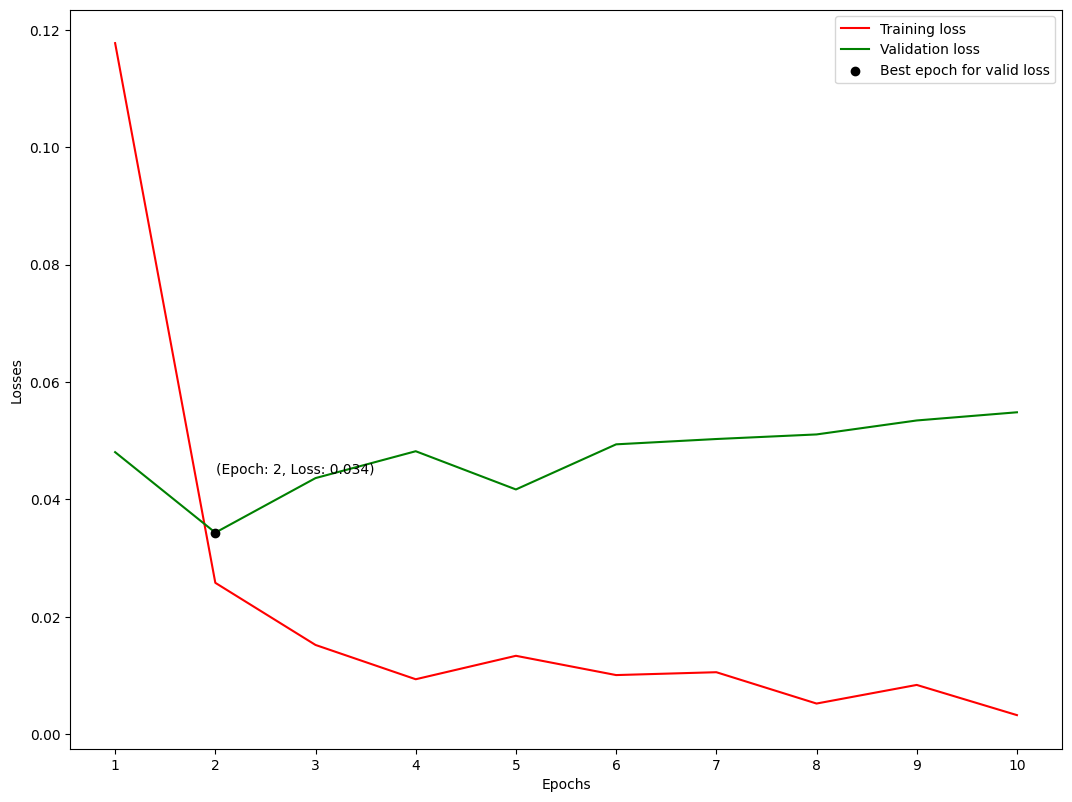

In [ ]:
# Plot

In [ ]:
# Test

f1: 0.991161351567799
accuracy: 0.9911616161616161
precision: 0.9912204368699842
recall: 0.9911616161616161


LEARNING_RATE = 4e-5 \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-6 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 300 \
POS_EMBEDDING_DIM = 256 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 3 \
DROPOUT = 0.5 \
DROPOUT_LSTM = 0.3 \
TRANFORMER_CHECKPOINT = "bert-base-uncased" \
ALL_HYPERNYMS = False


The lowest loss is at the epoch 2


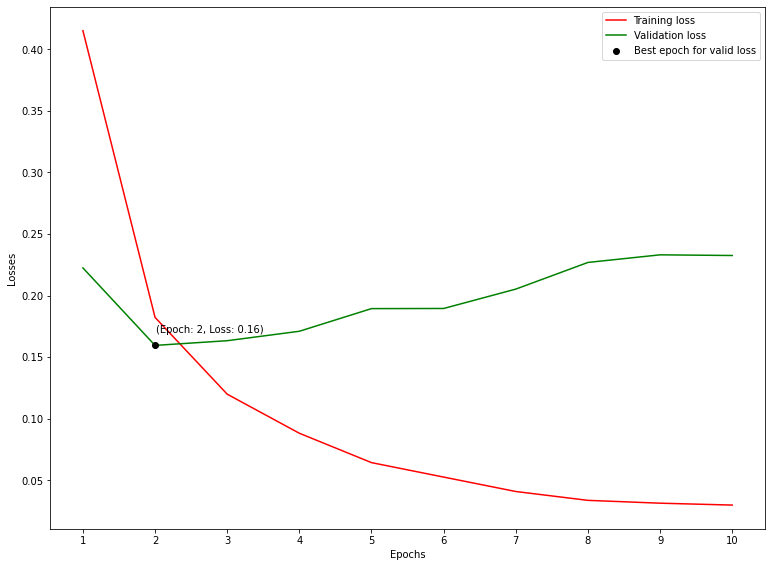

In [ ]:
# Plot 

In [ ]:
# Test

f1: 0.9549653647178027
accuracy: 0.95496632996633
precision: 0.955005339340416
recall: 0.95496632996633


LEARNING_RATE = 4e-4 \
WEIGHT_DECAY = 0.01 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 32 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 3 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.5 \
ALL_HYPERNYMS = True


The lowest loss is at the epoch 5


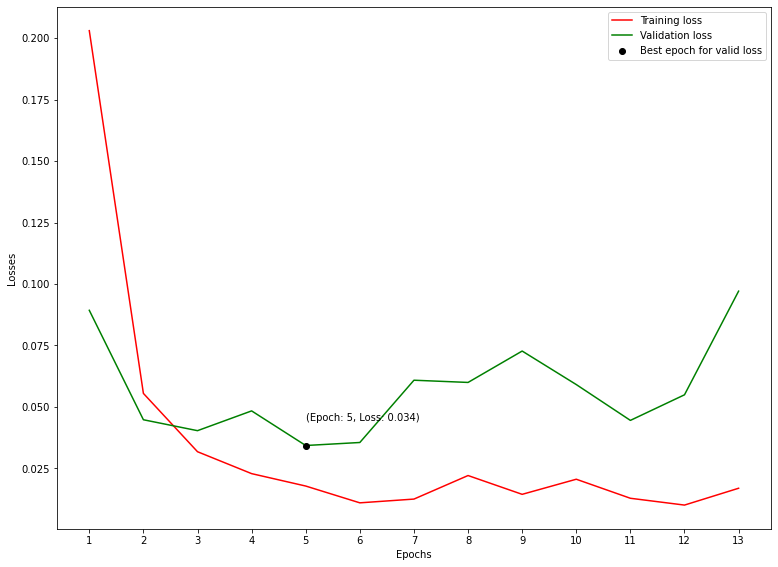

In [ ]:
# Plot

In [ ]:
# Test

f1: 0.9726273442621903
accuracy: 0.9726430976430976
precision: 0.9737336614361957
recall: 0.9726430976430976


LEARNING_RATE = 4e-5 \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-6 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 256 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.5 \
DROPOUT_LSTM = 0.3 \
TRANFORMER_CHECKPOINT = "bert-base-uncased" \
ALL_HYPERNYMS = True


The lowest loss is at the epoch 4


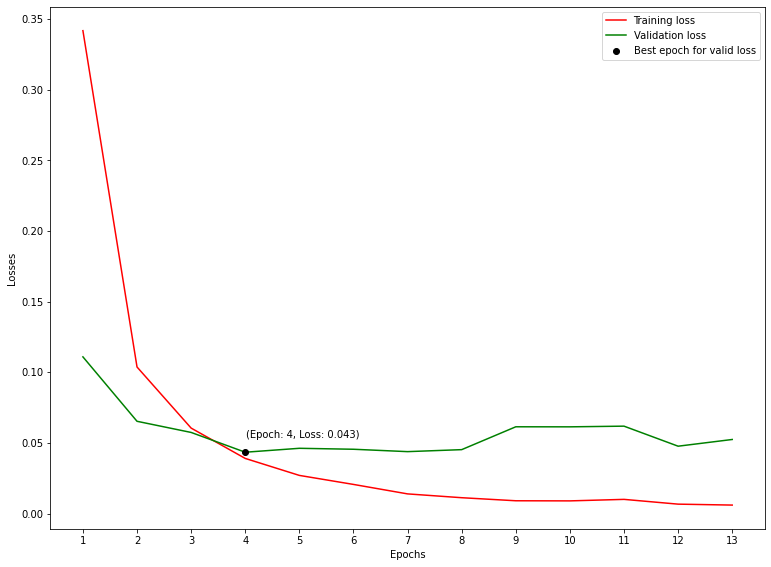

In [ ]:
# Plot

In [ ]:
# Test

f1: 0.991161351567799
accuracy: 0.9911616161616161
precision: 0.9912204368699842
recall: 0.9911616161616161


LEARNING_RATE = 4e-5 \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-6 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 300 \
POS_EMBEDDING_DIM = 256 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 3 \
DROPOUT = 0.5 \
DROPOUT_LSTM = 0.3 \
TRANFORMER_CHECKPOINT = "bert-base-uncased" \
ALL_HYPERNYMS = True


The lowest loss is at the epoch 4


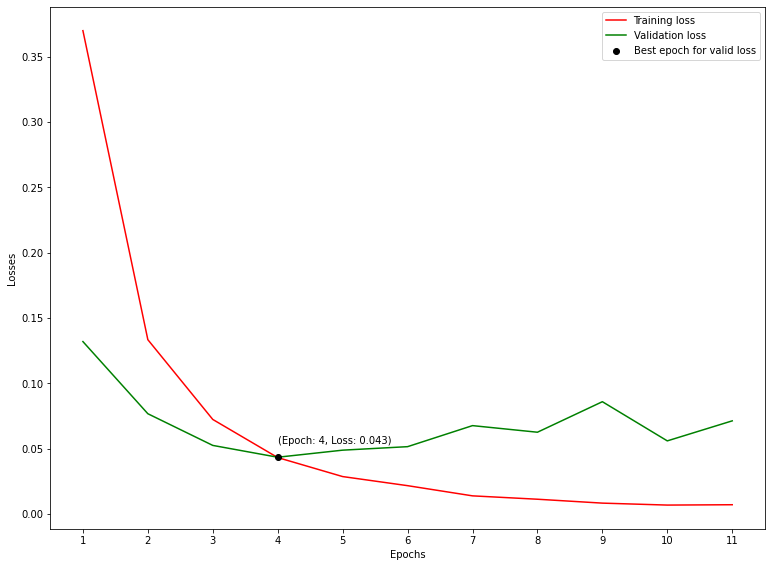

In [ ]:
# Plot

In [ ]:
# Test

f1: 0.988635781875461
accuracy: 0.9886363636363636
precision: 0.9887364418821379
recall: 0.9886363636363636


LEARNING_RATE = 4e-4 \
WEIGHT_DECAY = 0.01 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 32 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.3 \
DROPOUT_LSTM = 0.6 \
ALL_HYPERNYMS = False


The lowest loss is at the epoch 7


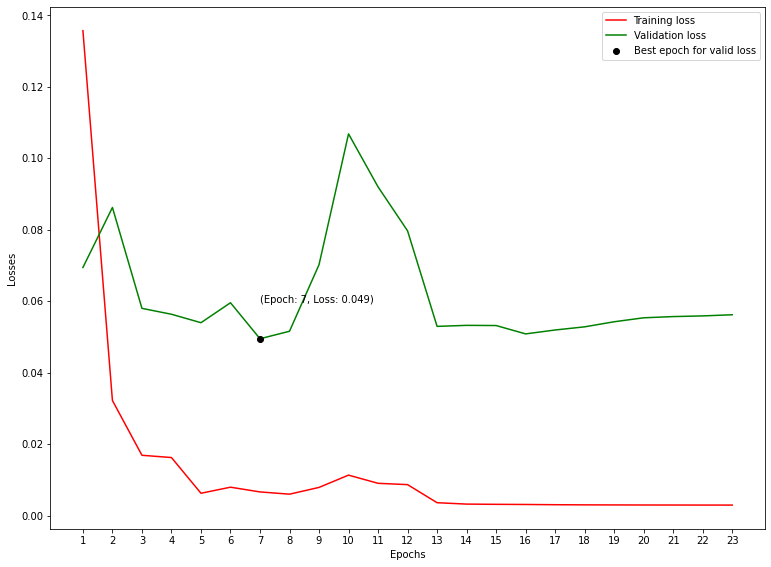

In [ ]:
# Plot 

In [ ]:
# Test

f1: 0.9920033315908966
accuracy: 0.992003367003367
precision: 0.9920120823144873
recall: 0.992003367003367


LEARNING_RATE = 4e-4 \
WEIGHT_DECAY = 0.01 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 32 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.3 \
DROPOUT_LSTM = 0.6 \
ALL_HYPERNYMS = True


The lowest loss is at the epoch 2


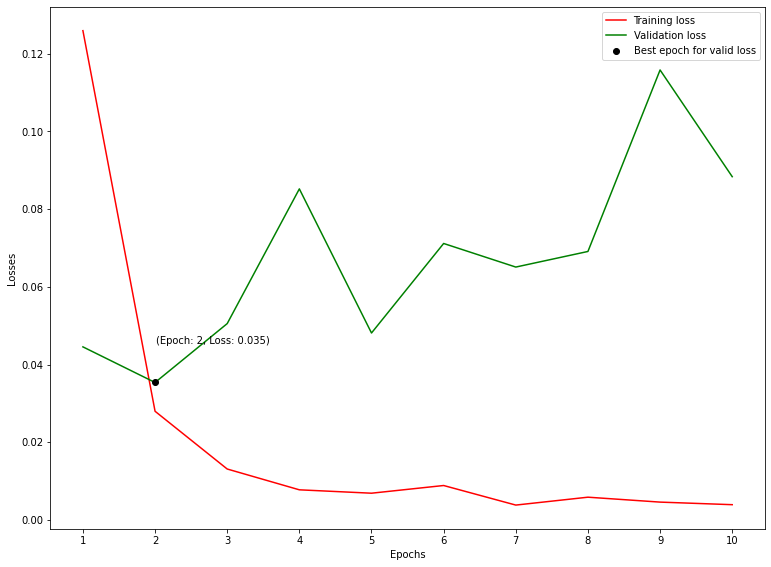

In [ ]:
# Plot

In [ ]:
# Test

f1: 0.9903195755266372
accuracy: 0.9903198653198653
precision: 0.9903785852215352
recall: 0.9903198653198653
